# Detailed Exploration of Universal Gate Set at Fixed Point

## Header

In [1]:
import numpy as np
import QDYN
from QDYN.shutil import mkdir
from QDYN.pulse import Pulse, pulse_tgrid
from QDYN.gate2q import Gate2Q
from QDYN.linalg import norm, vectorize
from os.path import join
from notebook_utils import (
    get_zeta_table, plot_zeta_data, filter_table, get_logical_energies_table,
    get_stage4_table, bare_decomposition, get_transition_table, J_target)
from mgplottools.io import writetotxt
from select_for_stage4 import GATE_RE, GATE_IM, GATE
from generate_zeta_universal import write_config
from analytical_pulses import AnalyticalPulse
from run_oct import propagate
from collections import OrderedDict
from zeta_systematic_variation import systematic_variation
import pandas as pd

In [2]:
H_left = GATE['H_left']
def write_target_gate_dat(rf, gate):
    writetotxt(join(rf, 'target_gate.dat'), GATE_RE[gate], GATE_IM[gate])

In [3]:
def J_PE(U):
    if U is None:
        return None
    else:
        C = U.closest_unitary().concurrence()
        max_loss = np.max(1.0 - U.logical_pops())
        return J_target('PE', C, max_loss)

def F_avg_H_left(U):
    if U is None:
        return None
    else:
        return U.F_avg(H_left)

In [4]:
from multiprocessing import Process
import os
def system(cmd):
    p = Process(target=os.system, args=(cmd,))
    p.start()
    return p

In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [6]:
get_zeta_table = QDYN.memoize.memoize(get_zeta_table)
get_zeta_table.load('zeta_table.cache')

In [7]:
zeta_table = get_zeta_table('./runs_050_RWA', T=50)

In [8]:
w_max = 1.0 # minimum frequency in the rotating frame to be resolved. (for calculation of nt)

In [9]:
n_qubit = 5; n_cavity = 6

## Analysis

In [10]:
wc = 6.35 # GHZ
w2 = 6.39 # GHz
w1 = 6.00 # GHz
root = './runs_zeta_detailed/w2_%dMHz_wc_%dMHz' % (w2*1000, wc*1000)
mkdir(root)

* what is the the entangling energy?

In [11]:
zeta = float(filter_table(zeta_table, [(w2, wc),])['zeta [MHz]']); zeta

-149.77200000000005

In [12]:
T_entangling = 500.0 / abs(zeta); T_entangling # ns

3.338407713057179

* Verify the PE. What do the logical eigenstates look like? What are the dressed qubit levels? What required spectral resolution do we anticipate?

In [76]:
T = T_entangling
rf = join(root, 'verify_PE'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()

concurrence: 1.00000


In [14]:
psi = {}; psi['00'], psi['01'], psi['10'], psi['11'] \
= np.genfromtxt(join(rf, 'logical_states.dat'), unpack=True, usecols=range(4))
for label in ['00', '01', '10', '11']:
    print("%s = %s" % (label, bare_decomposition(psi[label], n_qubit, n_cavity)))

00 = 100.0% {000}
01 = 39.5% {001} + 59.6% {010} + 1.0% {100}
10 = 3.8% {001} + 0.1% {010} + 96.1% {100}
11 = 4.6% {002} + 2.4% {011} + 0.7% {020} + 55.7% {101} + 34.9% {110} + 1.7% {200}


In [70]:
transition_table = get_transition_table(filter_table(zeta_table, [(w2, wc),]))
transition_table.reset_index(drop=True)

,E01 - E00 [MHz],E10 - E00 [MHz],E11 - E10 [MHz],E11 - E01 [MHz],bare w2 [MHz],bare w1 [MHz]
0,6446.97,5986.072,6297.198,5836.3,6390,6000


In [71]:
w1_dressed0 = transition_table['E10 - E00 [MHz]'][0] / 1000.0 # GHz
w1_dressed1 = transition_table['E11 - E01 [MHz]'][0] / 1000.0 # GHz
w2_dressed0 = transition_table['E01 - E00 [MHz]'][0] / 1000.0 # GHz
w2_dressed1 = transition_table['E11 - E10 [MHz]'][0] / 1000.0 # GHz

In [75]:
print w1_dressed0
print w1_dressed1
print w2_dressed0
print w2_dressed1

5.986072
5.8363
6.44697
6.297198


In [17]:
print("Separation of dressed frequencies, left qubit: %.3f MHz"
      % abs(float(transition_table['E11 - E01 [MHz]']) - float(transition_table['E10 - E00 [MHz]'])))
print("Separation of dressed frequencies, right qubit: %.3f MHz"
      % abs(float(transition_table['E11 - E10 [MHz]']) - float(transition_table['E01 - E00 [MHz]'])))

Separation of dressed frequencies, left qubit: 149.772 MHz
Separation of dressed frequencies, right qubit: 149.772 MHz


In [18]:
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')

Spectral resolution of pulse: 299.5 MHz


* What is the truncated drive-Hamiltonian in the dressed basis?

In [77]:
! tm_en_logical_eigenstates --ctrl {rf}

*** Read config file ./runs_zeta_detailed/w2_6390MHz_wc_6350MHz/verify_PE/config ***
*** Done reading config file ***
control Hamiltonian in the eigenbasis will be written to ham_ctrl_diag.dat
All eigenstates will be written to eigenstates.dump
Starting on Wed Feb 10 16:37:47 -0800 2016

This is tm_en_logical_eigenstates                                        rev.7515584cfa43c00b7482fa419a379e0a9ef606c6
 compiled on Tue Jan 26 18:18:50 2016 on host mlhpc2
QDYN 2.0dev revision 50b2d685df2070f8ff93d299e6b374b322a10cb7 (UNKNOWN)
  features: no-check-cheby, no-check-newton, no-parallel-ham, no-parallel-oct, backtraces
  compiled with ifort on Tue Jan 26 18:13:57 2016 on host mlhpc2

Number of qubit levels        =    5
Number of cavity levels       =    6
size(H):     150 x     150   --      0 MB

Orig. logical subspace levels:    1,    7,   31,   37

 Diagonalizing Drift Hamiltonian
 Done
 
level    48 in logical subspace (100.0000000% \Ket{000})
level    74 in logical subspace ( 59.57217

In [80]:
ctrl_dressed_i, ctrl_dressed_j = np.genfromtxt(join(rf, 'ham_ctrl_diag.dat'), usecols=(0,1), unpack=True, dtype=np.int)

In [82]:
ctrl_dressed_vals = np.genfromtxt(join(rf, 'ham_ctrl_diag.dat'), usecols=(2,), unpack=True, dtype=np.float64)

In [83]:
logical_levels = [48, 74, 45, 62]

In [91]:
ctrl_ham = np.zeros(shape=(4,4))
for l, v in enumerate(ctrl_dressed_vals):
    if ctrl_dressed_i[l] in logical_levels and ctrl_dressed_j[l] in logical_levels:
        i = logical_levels.index(ctrl_dressed_i[l])
        j = logical_levels.index(ctrl_dressed_j[l])
        if abs(v) > 1e-10:
            ctrl_ham[i,j] = v

In [92]:
print(ctrl_ham)

[[ 0.          0.314086   -0.09752039  0.        ]
 [ 0.314086    0.          0.          0.00135455]
 [-0.09752039  0.          0.          0.3980384 ]
 [ 0.          0.00135455  0.3980384   0.        ]]


In [93]:
ctrl_ham

array([[ 0.        ,  0.314086  , -0.09752039,  0.        ],
       [ 0.314086  ,  0.        ,  0.        ,  0.00135455],
       [-0.09752039,  0.        ,  0.        ,  0.3980384 ],
       [ 0.        ,  0.00135455,  0.3980384 ,  0.        ]])

In [86]:
x = [ 1, 2, 3]

In [87]:
x.index(2)

1

In [84]:
ctrl_ham = np.zeros(shape=(4,4))

* Verify the local gate

In [19]:
T = 2*T_entangling
rf = join(root, 'verify_SQ'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()

Spectral resolution of pulse: 149.8 MHz
concurrence: 0.00001


In [20]:
T = 4*T_entangling
rf = join(root, 'verify_SQ_2cycles'); mkdir(rf)
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=6.0, gate="CPHASE", J_T='SM', prop_guess='T')
pulse = Pulse(tgrid=pulse_tgrid(T, nt), time_unit='ns',ampl_unit='MHz')  # zero amplitude
pulse.write(join(rf, 'pulse.guess'))
print "Spectral resolution of pulse: %.1f MHz" % pulse.dw(freq_unit='MHz')
U = propagate(rf, 'pulse.guess', rwa=True, keep=True, force=True)
print "concurrence: %.5f" % U.concurrence()

Spectral resolution of pulse: 74.9 MHz
concurrence: 0.00003


* Can we compress the PE by adding a pulse and OCT?

In [21]:
compression = 0.9
wd = 0.5*(w1+w2)
rf = join(root, 'compress_PE_%.1f' % compression); mkdir(rf)

In [22]:
rf

'./runs_zeta_detailed/w2_6390MHz_wc_6350MHz/compress_PE_0.9'

In [23]:
# write runfolder
T = compression*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="CPHASE", J_T='PE', prop_guess='F')

In [24]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 200, 500]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=J_PE, n_procs=40)

,E0,w_L,fig_of_merit
0,0,6.000000,0.013236
1,0,6.390000,0.013236
2,0,6.195000,0.013236
3,0,5.986072,0.013236
4,0,5.836300,0.013236
5,0,5.911186,0.013236
6,0,6.446970,0.013236
7,0,6.297198,0.013236
8,0,6.372084,0.013236
13,50,5.836300,0.022007


In [31]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [32]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True, keep=None)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.987687
Loss: 0.000425


In [33]:
proc = system("./run_oct.py --target=PE --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [34]:
proc.join(); U = propagate(rf, 'pulse.dat', rwa=True, force=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

# Sun Feb 7 16:41:47 -0800 2016
# lambda_a =    9.760000E-03; lambda_intens =    0.000000E+00; lambda_b =    0.0
# it.                 J_T             g_a_int             g_b_int               
    0  4.321861070718E-04  0.000000000000E+00  0.000000000000E+00  4.32186107071
# pulse 1, lambda_a = 9.760000E-02
# Sun Feb 7 16:41:50 -0800 2016
# lambda_a =    1.220000E-02; lambda_intens =    0.000000E+00; lambda_b =    0.0
# it.                 J_T             g_a_int             g_b_int               
    0  4.321861070718E-04  0.000000000000E+00  0.000000000000E+00  4.32186107071
    1  4.321859702005E-04  3.872945743752E-11  0.000000000000E+00  4.32186008930


In [35]:
U.concurrence() - U_guess.concurrence()

0.0

Note: 0.7 and 1.2 also don't work

* Can we implement $H_L$ at $T = 2 T_\pi$ starting from field-free pulse?

In [36]:
rf = join(root, '1cycle_H_left'); mkdir(rf)
wd = 0.5*(w1+w2)

In [37]:
rf

'./runs_zeta_detailed/w2_6390MHz_wc_6350MHz/1cycle_H_left'

In [38]:
T = 2*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'H_left')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [39]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 50, 200, 500]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_H_left, n_procs=40)

,E0,w_L,fig_of_merit
26,200,6.372084,0.031741
19,200,6.390000,0.032492
33,500,6.446970,0.038568
35,500,6.372084,0.040493
25,200,6.297198,0.043759
24,200,6.446970,0.044051
28,500,6.390000,0.044512
34,500,6.297198,0.046819
29,500,6.195000,0.053226
20,200,6.195000,0.114526


In [40]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 50.0, 'T': T, 'w_L': 5.836300, 'w_d': 5.836300},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [41]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.049977
Loss: 0.004048


In [42]:
proc = system("./run_oct.py --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [ ]:
proc.join(); U = propagate(rf, 'pulse.dat', rwa=True, force=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

In [ ]:
U.concurrence() - U_guess.concurrence()

* Can we implement $H_L$ at $T = 80 T_\pi$ starting from field-free pulse?

In [56]:
rf = join(root, '40cycle_H_left'); mkdir(rf)
wd = 0.5*(w1+w2)

In [57]:
rf

'./runs_zeta_detailed/w2_6390MHz_wc_6350MHz/40cycle_H_left'

In [58]:
T = 80*T_entangling
nt = int(max(2000, 100 * w_max * T))
write_target_gate_dat(rf, 'H_left')
write_config(join(rf, 'config'), T, nt, wc, w2, wd=wd, gate="target_gate.dat", J_T='SM', prop_guess='F')

In [59]:
T

267.0726170445743

In [63]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 0.0, 'T': T, 'w_L': wd, 'w_d': wd},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
systematic_variation(rf, pulse, vary=OrderedDict([
            ('E0', [0.0, 20, 50, 100]), 
            ('w_L', [w1, w2, 0.5*(w1+w2),  
                     w1_dressed0, w1_dressed1, 0.5*(w1_dressed0+w1_dressed1),
                     w2_dressed0, w2_dressed1, 0.5*(w2_dressed0+w2_dressed1)])]),
            fig_of_merit=F_avg_H_left, n_procs=40)

,E0,w_L,fig_of_merit
28,100,6.390000,0.065370
34,100,6.297198,0.160431
35,100,6.372084,0.167946
33,100,6.446970,0.168966
19,50,6.390000,0.198423
32,100,5.911186,0.205069
24,50,6.446970,0.213586
15,20,6.446970,0.226901
30,100,5.986072,0.235576
21,50,5.986072,0.241762


In [64]:
pulse = AnalyticalPulse('1freq_rwa', T, nt,
            parameters={'E0': 50.0, 'T': T, 'w_L': 6.000000, 'w_d': 6.000000},
            t0=0.0, time_unit='ns', ampl_unit='MHz', freq_unit='MHz', mode="complex")
pulse.write(join(rf, 'pulse_guess.json'))

In [65]:
U_guess = propagate(rf, 'pulse_guess.json', rwa=True, force=True)
print("Concurrence: %f" % U_guess.closest_unitary().concurrence())
print("Loss: %f" % U_guess.pop_loss())

Concurrence: 0.147956
Loss: 0.050370


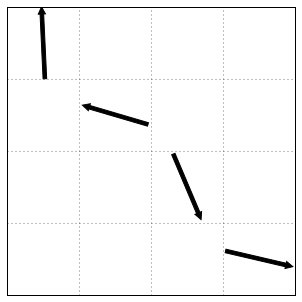

In [68]:
U_guess.arrow_plot()

In [69]:
proc = system("./run_oct.py --rwa --pre-simplex='pulse_guess.json' {rf}".format(rf=rf))

In [ ]:
proc.join(); U = propagate(rf, 'pulse.dat', rwa=True, force=True);
! tail {rf}/oct_iters.dat | cut -b 1-80

In [ ]:
U.concurrence() - U_guess.concurrence()